## Module 3 - In this jupyter notebook, perfomance indicators are calculated
* Step 3a - Set up: Import modules/libraries, inport data, create output folder
* Step 3b - Calculate uniformity
* Step 3c - Calculate efficiency (beneficial fraction)
* Step 3d - Calculate adquacy
* Step 3e - Calculate relative water deficit
**=====================================================================================================================**

![title](img/Fig3_1.png)

**=====================================================================================================================**
#### <span style='background :lightgreen' > References:
* Karimi, P., Bongani, B., Blatchford, M., and de Fraiture, C.: Global satellite-based ET products for the local level irrigation management: An application of irrigation performance assessment in the sugarbelt of Swaziland, Remote Sensing, 11, 705, 2019.
* Bastiaanssen, W. G., and Bos, M.: Irrigation performance indicators based on remotely sensed data: a review of literature, Irrigation and drainage systems, 13, 291-311, 1999.
* Bastiaanssen, W. G., Van der Wal, T., and Visser, T.: Diagnosis of regional evaporation by remote sensing to support irrigation performance assessment, Irrigation and Drainage Systems, 10, 1-23, 1996.

## Step 3a - Set up

## i) Import packages/libraries

In [ ]:
!pip install rasterio
!pip install rioxarray

In [37]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import rasterio as rio
import rioxarray as riox
import xarray as xr
from matplotlib import pyplot as plt

## ii) Import the input data
* Seasonal T, AETI, ETp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# get seasonal data
T_fhs    = glob.glob(r'/content/drive/MyDrive/WaPOR_IPA/Data/L3-T-season/*.tif')
AETI_fhs = glob.glob(r'/content/drive/MyDrive/WaPOR_IPA/Data/L3-AETI-season/*.tif')

## iii) Output folder: Make one or connect to the existing one

In [5]:
# output_folder
output_folderBF = r'/content/drive/MyDrive/WaPOR_IPA/Data/3_BeneficialFraction'  # create output folder
output_folderAd = r'/content/drive/MyDrive/WaPOR_IPA/Data/3_Adequacy'  # create output folder

# Make one if the folder does not exit
if not os.path.exists(output_folderBF):
    os.makedirs(output_folderBF)
if not os.path.exists(output_folderAd):
    os.makedirs(output_folderAd)

## Step 3b - Calculate uniformity of water consumption
* Equity is defined as the coefficients of variation (CV) of seasonal ETa in the area of interest.
* It measures the evenness of the water supply in an irrigation scheme.
* Note: CV of 0 to 10% is good, 10 to 25% is fair and CV > 25% is poor uniformity (Bastiaanssen et al., 1996)
<br/>

In [38]:
# Uniformity of water Consumption

for i in range(len(AETI_fhs)):
    with rio.open(AETI_fhs[i]) as dataset:
        AETI = dataset.read(1)  # Read the first band

    AETIm = np.nanmean(AETI)
    AETIsd = np.nanstd(AETI)

    CV_AETI = (AETIsd / AETIm) * 100

    # Identify the date from the file name
    date = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ')

    if CV_AETI < 10:
        U = 'Good Uniformity'
    elif 10 <= CV_AETI < 25:
        U = 'Fair Uniformity'
    else:
        U = 'Poor Uniformity'

    print('CV of AETI in', date, '=', round(CV_AETI, 1), ',', U)


CV of AETI in  season1 2020-10-01 to 2021-04-30 = 27.0 , Poor Uniformity


## Step 3c - Calculate efficiency (beneficial fraction)
* Beneficial fraction is the ratio of the water that is consumed as transpiration compared to overall field water consumption (ETa).
* $Beneficial fraction = \frac{T_a}{ET_a}$
* It is a measure of the efficiency of on farm water and agronomic practices in use of water for crop growth.

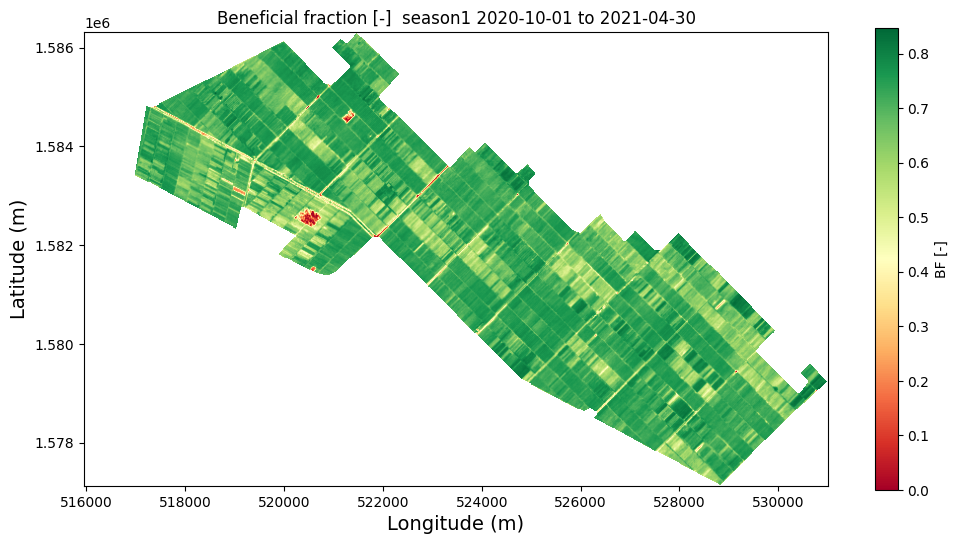

In [44]:

for Tfh, ETfh in zip(T_fhs, AETI_fhs):
    try:
        T = riox.open_rasterio(Tfh)
        AETI = riox.open_rasterio(ETfh)

        T_over_AETI = T / AETI

        # Get spatial extent
        spatial_extent = (T_over_AETI.x.min(), T_over_AETI.x.max(), T_over_AETI.y.min(), T_over_AETI.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'BF')
        output_fn = os.path.join(output_folderBF, basename)
        T_over_AETI.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = T_over_AETI.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='BF [-]')
        plt.xlabel('Longitude (m)', fontsize=14)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=14)
        plt.title('Beneficial fraction [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")



## Step 3d - Calculate adequacy (relative evapotranspiration)
$Adequacy= \frac{ET_a}{ET_p}$

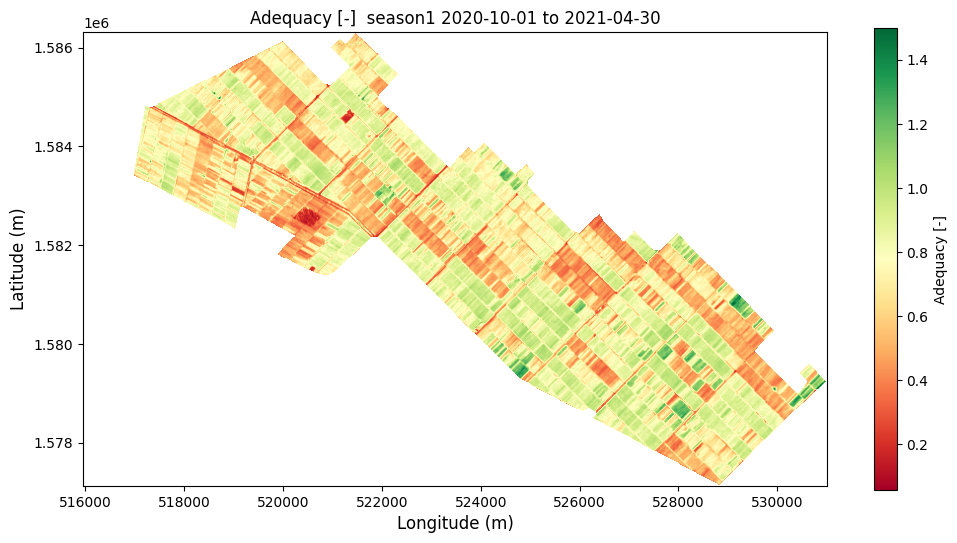

In [41]:

for ETfh in AETI_fhs:
    try:
        AETI = riox.open_rasterio(ETfh)

        # Compute ETp as the 95th percentile of AETI
        ETp_value = np.nanpercentile(AETI.values, 95)
        ETp = xr.full_like(AETI, ETp_value)

        ETa_by_ETp = AETI / ETp

        # Get spatial extent
        spatial_extent = (ETa_by_ETp.x.min(), ETa_by_ETp.x.max(), ETa_by_ETp.y.min(), ETa_by_ETp.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'Adequacy')
        output_fn = os.path.join(output_folderAd, basename)
        ETa_by_ETp.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = ETa_by_ETp.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='Adequacy [-]')
        plt.xlabel('Longitude (m)', fontsize=12)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=12)
        plt.title('Adequacy [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")

## Step 3e - Calculate Relative water Deficit (RWD)
$RWD= 1-\frac{ET_a}{ET_x}$
<br/>${ET_x} = $ Can be ETp or 99 percentile of the actual evapotranspiration

In [42]:
# Collecting GeoInfo such as projection, the x and y axis from the first file
in_fh = AETI_fhs[0]
AETI_extend = riox.open_rasterio(in_fh)
spatial_extent = (AETI_extend.x.min(), AETI_extend.x.max(), AETI_extend.y.min(), AETI_extend.y.max())

for i in range(len(AETI_fhs)):
    try:
        # Open the AETI file using rioxarray
        AETI = riox.open_rasterio(AETI_fhs[i])

        # Reshape the array
        AETI1_1D = np.reshape(AETI.values, AETI.shape[1] * AETI.shape[2])
        ETx = np.nanpercentile(AETI1_1D, 95)

        AETI_mean = np.nanmean(AETI.values)

        RWD = 1 - (AETI_mean / ETx)

        # Identify the date from the file name
        date = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ')

        print('Relative water deficit', date, '=', round(RWD, 2))

    except Exception as e:
        print(f"An error occurred with file {AETI_fhs[i]}: {e}")


Relative water deficit  season1 2020-10-01 to 2021-04-30 = 0.27
